In [1]:
import pandas as pd
import numpy as np
import json
import math

from sklearn import tree
import sklearn
import graphviz

### Data Cleaning and One-Hot Encoding

In [2]:
loans = pd.read_csv('lending-club-data.csv', low_memory = False)

In [5]:
di = {1: -1, 0: 1}
loans['safe_loans'] = loans['bad_loans'].map(di)
del loans['bad_loans']

In [7]:
target = 'safe_loans'
features = ['grade',                     # grade of the loan (categorical)
            'sub_grade_num',             # sub-grade of the loan as a number from 0 to 1
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'payment_inc_ratio',         # ratio of the monthly payment to income
            'delinq_2yrs',               # number of delinquincies
             'delinq_2yrs_zero',          # no delinquincies in last 2 years
            'inq_last_6mths',            # number of creditor inquiries in last 6 months
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'open_acc',                  # number of open credit accounts
            'pub_rec',                   # number of derogatory public records
            'pub_rec_zero',              # no derogatory public records
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
            'int_rate',                  # interest rate of the loan
            'total_rec_int',             # interest received to date
            'annual_inc',                # annual income of borrower
            'funded_amnt',               # amount committed to the loan
            'funded_amnt_inv',           # amount committed by investors for the loan
            'installment',               # monthly payment owed by the borrower
           ]

In [10]:
loans = loans[[target] + features].dropna()

### one-hot encoding

In [12]:
features = loans.columns.values

categorical_variables = []
for feat_name, feat_type in zip(dict(loans.dtypes).keys(), dict(
    loans.dtypes).values()) :
    if feat_type == object:
        categorical_variables.append(feat_name)

for feature in categorical_variables:
    loans_data_one_hot_encoded = pd.get_dummies(loans[feature],
                                                prefix=feature)
    loans =pd.concat([loans,loans_data_one_hot_encoded],axis=1)
    del loans[feature] 

In [14]:
len(loans.columns)

45

In [18]:
with open ('module-8-assignment-1-train-idx.json') as json_data:
    train_idx = json.load(json_data)

with open ('module-8-assignment-1-validation-idx.json') as json_data:
    valid_idx = json.load(json_data)
    
train_data = loans.iloc[train_idx,]
valid_data = loans.iloc[valid_idx,]

In [19]:
train_data.head(2)

,safe_loans,sub_grade_num,short_emp,emp_length_num,dti,payment_inc_ratio,delinq_2yrs,delinq_2yrs_zero,inq_last_6mths,last_delinq_none,...,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding
1,-1,0.8,1,1,1.00,2.3932,0.0,1.0,5.0,1,...,0,0,0,0,0,0,0,0,0,0
6,-1,0.4,0,5,5.55,4.5717,0.0,1.0,2.0,1,...,0,0,0,0,0,0,0,1,0,0


### Gradient boosted tree classifier

In [17]:
import sklearn.ensemble

GradientBoostingClassifier(loss=’deviance’, learning_rate=0.1, n_estimators=100, subsample=1.0, criterion=’friedman_mse’, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, min_impurity_split=None, init=None, random_state=None, max_features=None, verbose=0, max_leaf_nodes=None, warm_start=False, presort=’auto’)

In [22]:
gradient_boost = sklearn.ensemble.GradientBoostingClassifier(max_depth = 6, n_estimators=5)
model_5 = gradient_boost.fit(train_data.drop('safe_loans', axis = 1), train_data['safe_loans'])

In [23]:
model_5

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=6,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=5, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

#### Verification on four Cases

In [24]:
validation_data = valid_data

validation_safe_loans = validation_data[validation_data[target] == 1]
validation_risky_loans = validation_data[validation_data[target] == -1]

sample_validation_data_risky = validation_risky_loans[0:2]
sample_validation_data_safe = validation_safe_loans[0:2]

sample_validation_data = sample_validation_data_safe.append(sample_validation_data_risky)
sample_validation_data

,safe_loans,sub_grade_num,short_emp,emp_length_num,dti,payment_inc_ratio,delinq_2yrs,delinq_2yrs_zero,inq_last_6mths,last_delinq_none,...,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding
22,1,0.2,0,3,29.44,6.30496,0.0,1.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0
26,1,0.6,1,1,12.19,13.49520,0.0,1.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0
24,-1,0.4,0,3,13.97,2.96736,3.0,0.0,0.0,0,...,0,0,0,0,0,0,1,0,0,0
41,-1,1.0,0,11,16.33,1.90524,0.0,1.0,0.0,1,...,1,0,0,0,0,0,0,0,0,0


In [29]:
predictions_model_5 = model_5.predict(sample_validation_data.drop('safe_loans', axis=1))
probabilities_model_5 = model_5.predict_proba(sample_validation_data.drop('safe_loans', axis=1))

In [28]:
predictions_model_5

array([ 1,  1, -1,  1])

In [30]:
probabilities_model_5 

array([[0.41642331, 0.58357669],
       [0.46949689, 0.53050311],
       [0.53807792, 0.46192208],
       [0.39591639, 0.60408361]])

#### Verification on the Entire Validation Set

In [31]:
model_5.score(validation_data.drop('safe_loans', axis = 1), validation_data['safe_loans'])

0.6614605773373546

In [33]:
predictions_5 = model_5.predict(validation_data.drop('safe_loans', axis = 1))

#### Calculate number of false positives and false negatives

In [44]:
# Count false positives
count = 0
for i in range(len(predictions_5)):
    if predictions_5[i] == 1 and validation_data['safe_loans'].tolist()[i]==-1:
        count += 1

In [46]:
# Count false negatives
count1 = 0
for i in range(len(predictions_5)):
    if predictions_5[i] == -1 and validation_data['safe_loans'].tolist()[i]==1:
        count1 += 1

In [47]:
20000*count + 10000*count1

47950000

#### Prediction Probability

In [48]:
probability_5 = model_5.predict_proba(validation_data.drop(
    'safe_loans', axis = 1))

probability_5 = pd.DataFrame(probability_5, columns=list('xy'))
probability_5 = probability_5['y'].tolist()

In [56]:
validation_data['proba'] = probability_5

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [60]:
validation_data.sort_values(by = 'proba', ascending = False).head(5)

,safe_loans,sub_grade_num,short_emp,emp_length_num,dti,payment_inc_ratio,delinq_2yrs,delinq_2yrs_zero,inq_last_6mths,last_delinq_none,...,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,proba
8021,-1,0.4,0,4,12.73,12.16700,0.0,1.0,1.0,1,...,0,0,0,0,0,0,0,0,0,0.673059
109930,1,0.4,0,4,13.75,2.03093,0.0,1.0,1.0,1,...,0,0,0,0,0,0,0,0,0,0.661468
10689,1,0.4,0,5,7.82,1.12313,0.0,1.0,1.0,1,...,1,0,0,0,0,0,0,0,0,0.661468
13391,1,0.2,0,2,8.18,6.03200,0.0,1.0,0.0,1,...,0,0,0,0,0,1,0,0,0,0.661468
89078,1,0.4,0,11,14.95,2.26242,0.0,1.0,1.0,1,...,0,0,0,0,0,0,0,0,0,0.661468


In [63]:
grade_names = ['grade_A',
       'grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G']
top_5 = validation_data.sort_values(by='proba').head(5)

In [64]:
top_5[grade_names]

,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G
58794,0,0,1,0,0,0,0
84508,0,0,1,0,0,0,0
27502,0,0,1,0,0,0,0
101746,0,0,0,1,0,0,0
114781,0,0,0,1,0,0,0


### Effects of adding more trees

In [75]:
gradient_boost_10 = sklearn.ensemble.GradientBoostingClassifier(max_depth = 6, 
                                                        n_estimators=10)
model_10 = gradient_boost_10.fit(train_data.drop('safe_loans', axis = 1),
                               train_data['safe_loans'])

gradient_boost_50 = sklearn.ensemble.GradientBoostingClassifier(max_depth = 6, 
                                                        n_estimators=50)
model_50 = gradient_boost_50.fit(train_data.drop('safe_loans', axis = 1),
                               train_data['safe_loans'])


gradient_boost_100 = sklearn.ensemble.GradientBoostingClassifier(max_depth = 6, 
                                                        n_estimators=100)
model_100 = gradient_boost_100.fit(train_data.drop('safe_loans', axis = 1),
                               train_data['safe_loans'])


gradient_boost_200 = sklearn.ensemble.GradientBoostingClassifier(max_depth = 6, 
                                                        n_estimators=200)
model_200 = gradient_boost_200.fit(train_data.drop('safe_loans', axis = 1),
                               train_data['safe_loans'])


gradient_boost_500 = sklearn.ensemble.GradientBoostingClassifier(max_depth = 6, 
                                                        n_estimators=500)
model_500 = gradient_boost_500.fit(train_data.drop('safe_loans', axis = 1),
                               train_data['safe_loans'])

In [88]:
validation_errors = []

validation_errors.append(1- model_10.score(validation_data.drop(['safe_loans' , 'proba'], axis = 1), 
               validation_data['safe_loans']))
validation_errors.append(1- model_50.score(validation_data.drop(['safe_loans' , 'proba'], axis = 1), 
               validation_data['safe_loans']))
validation_errors.append(1- model_100.score(validation_data.drop(['safe_loans' , 'proba'], axis = 1), 
               validation_data['safe_loans']))
validation_errors.append(1- model_200.score(validation_data.drop(['safe_loans' , 'proba'], axis = 1), 
               validation_data['safe_loans']))
validation_errors.append(1- model_500.score(validation_data.drop(['safe_loans' , 'proba'], axis = 1), 
               validation_data['safe_loans']))

In [89]:
train_errors = []

train_errors.append(1- model_10.score(train_data.drop(['safe_loans'], axis = 1), 
               train_data['safe_loans']))
train_errors.append(1- model_50.score(train_data.drop(['safe_loans'], axis = 1), 
               train_data['safe_loans']))
train_errors.append(1- model_100.score(train_data.drop(['safe_loans'], axis = 1), 
               train_data['safe_loans']))
train_errors.append(1- model_200.score(train_data.drop(['safe_loans'], axis = 1), 
               train_data['safe_loans']))
train_errors.append(1- model_500.score(train_data.drop(['safe_loans' ], axis = 1), 
               train_data['safe_loans']))

In [77]:
import matplotlib.pyplot as plt
%matplotlib inline

def make_figure(dim, title, xlabel, ylabel, legend):
    plt.rcParams['figure.figsize'] = dim
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend is not None:
        plt.legend(loc=legend, prop={'size':15})
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

In [90]:
train_errors

[0.3283269297939224,
 0.28324242994169646,
 0.2533920846879282,
 0.2153738681856041,
 0.13458179961847438]

In [92]:
validation_errors

[0.3336923739767341,
 0.31839724256785873,
 0.30978026712623874,
 0.3107496768634209,
 0.3130116329168462]

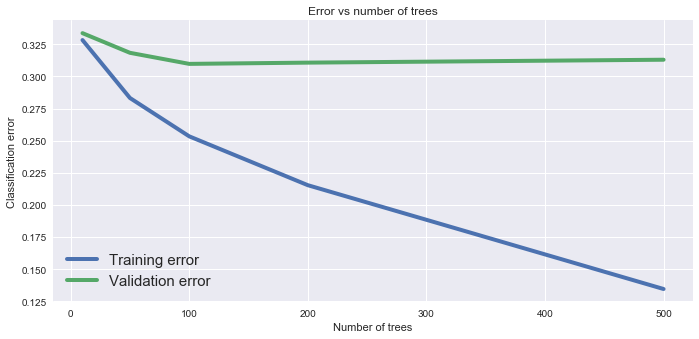

In [97]:
plt.plot([10, 50, 100, 200, 500], train_errors, linewidth=4.0, 
         label='Training error')
plt.plot([10, 50, 100, 200, 500], validation_errors, linewidth=4.0, 
         label='Validation error')

make_figure(dim=(10,5), title='Error vs number of trees',
            xlabel='Number of trees',
            ylabel='Classification error',
            legend='best')
seaborn.set_style('darkgrid')

### AdaBoosting 

In [98]:
loans = pd.read_csv('lending-club-data.csv', low_memory = False)
di = {1: -1, 0: 1}
loans['safe_loans'] = loans['bad_loans'].map(di)
del loans['bad_loans']

In [99]:
features = ['grade',              # grade of the loan
            'term',               # the term of the loan
            'home_ownership',     # home ownership status: own, mortgage or rent
            'emp_length',         # number of years of employment
           ]
#loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)
#loans.remove_column('bad_loans')
target = 'safe_loans'
loans = loans[features + [target]]

In [100]:
features = loans.columns.values

categorical_variables = []
for feat_name, feat_type in zip(dict(loans.dtypes).keys(), dict(
    loans.dtypes).values()) :
    if feat_type == object:
        categorical_variables.append(feat_name)

for feature in categorical_variables:
    loans_data_one_hot_encoded = pd.get_dummies(loans[feature],
                                                prefix=feature)
    loans =pd.concat([loans,loans_data_one_hot_encoded],axis=1)
    del loans[feature] 

In [101]:
with open ('module-8-assignment-2-train-idx.json') as json_data:
    train_idx = json.load(json_data)

with open ('module-8-assignment-2-test-idx.json') as json_data:
    test_idx = json.load(json_data)
    
train_data = loans.iloc[train_idx,]
test_data = loans.iloc[test_idx,]

In [114]:
features = train_data.columns.values[1:]
features

array(['grade_A', 'grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F',
       'grade_G', 'term_ 36 months', 'term_ 60 months',
       'home_ownership_MORTGAGE', 'home_ownership_OTHER',
       'home_ownership_OWN', 'home_ownership_RENT', 'emp_length_1 year',
       'emp_length_10+ years', 'emp_length_2 years', 'emp_length_3 years',
       'emp_length_4 years', 'emp_length_5 years', 'emp_length_6 years',
       'emp_length_7 years', 'emp_length_8 years', 'emp_length_9 years',
       'emp_length_< 1 year'], dtype=object)

### Calculate Weighted Error

In [207]:
def intermediate_node_weighted_mistakes(labels_in_node, data_weights):
    
    # Sum the weights of all entries with label +1
    total_weight_positive = sum(data_weights[labels_in_node == +1])
    
    # Weight of mistakes for predicting all -1's is equal to the sum above

    
    # Sum the weights of all entries with label -1
    total_weight_negative = sum(data_weights[labels_in_node == -1])
    
    # Weight of mistakes for predicting all +1's is equal to the sum above

    # Return the tuple (weight, class_label) representing the lower of the two weights
    #    class_label should be an integer of value +1 or -1.
    # If the two weights are identical, return (weighted_mistakes_all_positive,+1)
    
    if (total_weight_positive < total_weight_negative):
        return (total_weight_positive, -1)
    else:
        return (total_weight_negative, +1)

In [208]:
def best_splitting_feature(data, features, target, data_weights):
    
    # These variables will keep track of the best feature and the corresponding error
    best_feature = None
    best_error = float('+inf') 
    num_points = float(len(data))

    # Loop through each feature to consider splitting on that feature
    for feature in features:
        
        # The left split will have all data points where the feature value is 0
        # The right split will have all data points where the feature value is 1
        left_split = data[data[feature] == 0]
        right_split = data[data[feature] == 1]
        
        # Apply the same filtering to data_weights to create left_data_weights, right_data_weights
        left_data_weights = data_weights[data[feature] == 0]
        right_data_weights = data_weights[data[feature] == 1]
                    
        # DIFFERENT HERE
        # Calculate the weight of mistakes for left and right sides
        ## YOUR CODE HERE
        left_weighted_mistakes, left_class = intermediate_node_weighted_mistakes(
            left_split[target], 
             left_data_weights)
       
        right_weighted_mistakes, right_class = intermediate_node_weighted_mistakes(
            right_split[target], 
             right_data_weights)
        
        # DIFFERENT HERE
        # Compute weighted error by computing
        #  ( [weight of mistakes (left)] + [weight of mistakes (right)] ) 
        # / [total weight of all data points]
        error = (left_weighted_mistakes+ 
                 right_weighted_mistakes)/sum(data_weights)
        
        # If this is the best error we have found so far, store the feature and the error
        if error < best_error:
            best_feature = feature
            best_error = error
    
    # Return the best feature we found
    return best_feature

#### Build the tree

In [105]:
def create_leaf(target_values, data_weights):
    
    # Create a leaf node
    leaf = {'splitting_feature' : None,
            'is_leaf': True}
    
    # Computed weight of mistakes.
    # Store the predicted class (1 or -1) in leaf['prediction']
    weighted_error, best_class = intermediate_node_weighted_mistakes(target_values, data_weights)
    leaf['prediction'] = best_class
    
    return leaf

In [209]:
def weighted_decision_tree_create(data, 
                                  features, target, 
                                  data_weights, current_depth = 1, 
                                  max_depth = 10):
    
    remaining_features = features[:] # Make a copy of the features.
    target_values = data[target]
    print ("--------------------------------------------------------------------")
    print ("Subtree, depth = %s (%s data points)." % (current_depth, len(target_values)))
    
    # Stopping condition 1. Error is 0.
    if intermediate_node_weighted_mistakes(target_values, data_weights)[0] <= 1e-15:
        print ("Stopping condition 1 reached.")                
        return create_leaf(target_values, data_weights)
    
    # Stopping condition 2. No more features.
    if remaining_features == []:
        print ("Stopping condition 2 reached." )              
        return create_leaf(target_values, data_weights)    
    
    # Additional stopping condition (limit tree depth)
    if current_depth > max_depth:
        print ("Reached maximum depth. Stopping for now.")
        return create_leaf(target_values, data_weights)
    
    # If all the datapoints are the same, splitting_feature will be None. Create a leaf
    splitting_feature = best_splitting_feature(data, 
                                               features, 
                                               target, 
                                               data_weights)
    
    remaining_features = remaining_features[remaining_features!=splitting_feature]
        
    left_split = data[data[splitting_feature] == 0]
    right_split = data[data[splitting_feature] == 1]
    

    left_data_weights = data_weights[data[splitting_feature] == 0]    
    right_data_weights = data_weights[data[splitting_feature] == 1]
    
    print ("Split on feature %s. (%s, %s)" % (\
              splitting_feature, len(left_split), len(right_split)))
    
    # Create a leaf node if the split is "perfect"
    if len(left_split) == len(data):
        print ("Creating leaf node.")
        return create_leaf(left_split[target], data_weights)
    
    if len(right_split) == len(data):
        print ("Creating leaf node.")
        return create_leaf(right_split[target], data_weights)
    
    # Repeat (recurse) on left and right subtrees
    left_tree = weighted_decision_tree_create(
        left_split, remaining_features, target, left_data_weights, current_depth + 1, max_depth)
    right_tree = weighted_decision_tree_create(
        right_split, remaining_features, target, right_data_weights, current_depth + 1, max_depth)
    
    return {'is_leaf'          : False, 
            'prediction'       : None,
            'splitting_feature': splitting_feature,
            'left'             : left_tree, 
            'right'            : right_tree}    

In [107]:
def count_nodes(tree):
    if tree['is_leaf']:
        return 1
    return 1 + count_nodes(tree['left']) + count_nodes(tree['right'])

In [242]:
def classify(tree, x, annotate = False):
       # if the node is a leaf node.
    if tree['is_leaf']:
        if annotate:
             print ("At leaf, predicting %s" % tree['prediction'])
        return tree['prediction']
    else:
        # split on feature.
        #print(tree['splitting_feature'])
        #print(x[tree['splitting_feature']])
        split_feature_value = x[tree['splitting_feature']]
        if annotate:
             print ("Split on %s = %s" % (tree['splitting_feature'], split_feature_value))
        if split_feature_value == 0:
            return classify(tree['left'], x, annotate)
        else:
            return classify(tree['right'], x, annotate)

In [243]:
def evaluate_classification_error(tree, data):
    # Apply the classify(tree, x) to each row in your data
    prediction = data.apply(lambda x: classify(tree, x), axis = 1)
    
    # Once you've made the predictions, calculate the classification error
    return (prediction != data[target]).sum() / float(len(data))

In [244]:
evaluate_classification_error(small_data_decision_tree_subset_20, train_data)

0.48124865678057166

In [245]:
evaluate_classification_error(small_data_decision_tree_subset_20, subset_20)

0.05

In [234]:
top_10 = train_data.iloc[:10]

In [236]:
top_10

,safe_loans,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,term_ 36 months,term_ 60 months,...,emp_length_10+ years,emp_length_2 years,emp_length_3 years,emp_length_4 years,emp_length_5 years,emp_length_6 years,emp_length_7 years,emp_length_8 years,emp_length_9 years,emp_length_< 1 year
1,-1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
6,-1,0,0,0,0,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0
7,-1,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
10,-1,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
12,-1,0,1,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
18,-1,0,1,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
21,-1,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
23,-1,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
45,-1,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
48,-1,0,0,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0


In [235]:
bottom_10 = train_data.iloc[-10:]

In [239]:
subset_20 = pd.concat([top_10, bottom_10], axis = 0)

In [115]:
features

array(['grade_A', 'grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F',
       'grade_G', 'term_ 36 months', 'term_ 60 months',
       'home_ownership_MORTGAGE', 'home_ownership_OTHER',
       'home_ownership_OWN', 'home_ownership_RENT', 'emp_length_1 year',
       'emp_length_10+ years', 'emp_length_2 years', 'emp_length_3 years',
       'emp_length_4 years', 'emp_length_5 years', 'emp_length_6 years',
       'emp_length_7 years', 'emp_length_8 years', 'emp_length_9 years',
       'emp_length_< 1 year'], dtype=object)

In [229]:
train_data.iloc[0]['home_ownership_OWN']

0

In [116]:
target

'safe_loans'

In [213]:
# Assign weights
example_data_weights = [1.] * 10 + [0.]*(len(train_data) - 20) + [1.] * 10
example_data_weights = np.array(example_data_weights)

In [214]:
# Train a weighted decision tree model.
small_data_decision_tree_subset_20 = weighted_decision_tree_create(train_data, 
                                                                   features,
                                                                   target,
                         example_data_weights, max_depth=2)

--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).


/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


Split on feature home_ownership_RENT. (20514, 16710)
--------------------------------------------------------------------
Subtree, depth = 2 (20514 data points).
Split on feature grade_F. (19613, 901)
--------------------------------------------------------------------
Subtree, depth = 3 (19613 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 3 (901 data points).
Stopping condition 1 reached.
--------------------------------------------------------------------
Subtree, depth = 2 (16710 data points).
Split on feature grade_D. (13315, 3395)
--------------------------------------------------------------------
Subtree, depth = 3 (13315 data points).
Stopping condition 1 reached.
--------------------------------------------------------------------
Subtree, depth = 3 (3395 data points).
Stopping condition 1 reached.


### Implementing your own Adaboost (on decision stumps)

In [254]:
from math import log
from math import exp

def adaboost_with_tree_stumps(data, features, target, num_tree_stumps):
    # start with unweighted data
    alpha = np.array([1.]*len(data))
    weights = []
    tree_stumps = []
    target_values = data[target]
    
    for t in range(num_tree_stumps):
        print ('=====================================================')
        print ('Adaboost Iteration %d' % t)
        print ('=====================================================' )      
       
        # Learn a weighted decision tree stump. Use max_depth=1
        tree_stump = weighted_decision_tree_create(data, features, 
                                                   target, 
                                                   data_weights=alpha, 
                                                   max_depth=1)
        tree_stumps.append(tree_stump)
        
        # Make predictions
        predictions = data.apply(lambda x: classify(tree_stump, x),axis = 1)
        
        # Produce a Boolean array indicating whether
        # each data point was correctly classified
        is_correct = predictions == target_values
        is_wrong   = predictions != target_values
        
        # Compute weighted error
        error = sum(alpha[is_wrong])
        correct = sum(alpha[is_correct])
        
        weighted_error = error/(error + correct)
        
        # Compute model coefficient using weighted error
        # YOUR CODE HERE
        weight = 0.5*log((1-weighted_error)/weighted_error)
        weights.append(weight)
        
        # Adjust weights on data point
        adjustment = is_correct.apply(lambda is_correct : exp(-weight) if is_correct else exp(weight))
        
        # Scale alpha by multiplying by adjustment
        # Then normalize data points weights
        alpha = alpha*adjustment
        alpha_sum = sum(alpha)
        alpha = alpha/alpha_sum
    
    return weights, tree_stumps

In [248]:
train_data
features
target
num_tree_stumps = 10

In [255]:
weights_10, tree_stumps_10 = adaboost_with_tree_stumps(train_data, 
                                                       features, 
                                                       target, 
                                                       num_tree_stumps)

Adaboost Iteration 0
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).


/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


Split on feature term_ 36 months. (9223, 28001)
--------------------------------------------------------------------
Subtree, depth = 2 (9223 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (28001 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 1
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).


/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


Split on feature grade_A. (32094, 5130)
--------------------------------------------------------------------
Subtree, depth = 2 (32094 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (5130 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 2
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade_D. (30465, 6759)
--------------------------------------------------------------------
Subtree, depth = 2 (30465 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (6759 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 3
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature home_ownership_MORTGAGE. (19846, 17378)
-----

In [257]:
def predict_adaboost(stump_weights, tree_stumps, data):
    
    scores = np.array([0.]*len(data))
    
    for i, tree_stump in enumerate(tree_stumps):
        predictions = data.apply(lambda x: classify(tree_stump, x), axis = 1)
        
        # Accumulate predictions on scaores array
        scores = scores+predictions*stump_weights[i]

    return scores.apply(lambda score : +1 if score > 0 else -1)

{ 
   - 'is_leaf'            : True/False.
   - 'prediction'         : Prediction at the leaf node.
   - 'left'               : (dictionary corresponding to the left tree).
   - 'right'              : (dictionary corresponding to the right tree).
   - 'features_remaining' : List of features that are posible splits.
   - 
}

In [262]:
for i, tree_stump in enumerate(tree_stumps_10):
    print('Stump %d has weight %f' % (i, weights_10[i]))

Stump 0 has weight 0.158029
Stump 1 has weight 0.176824
Stump 2 has weight 0.093119
Stump 3 has weight 0.072889
Stump 4 has weight 0.067063
Stump 5 has weight 0.064569
Stump 6 has weight 0.054561
Stump 7 has weight 0.043511
Stump 8 has weight 0.028989
Stump 9 has weight 0.019333


In [264]:
num_tree_stumps = 30

weights_30, tree_stumps_30 = adaboost_with_tree_stumps(train_data, 
                                                       features, 
                                                       target, 
                                                       num_tree_stumps)

Adaboost Iteration 0
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).


/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


Split on feature term_ 36 months. (9223, 28001)
--------------------------------------------------------------------
Subtree, depth = 2 (9223 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (28001 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 1
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade_A. (32094, 5130)
--------------------------------------------------------------------
Subtree, depth = 2 (32094 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (5130 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 2
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade_D. (30465, 6759)
--------------

In [265]:


error_all = []
for n in range(1, 31):
    predictions = predict_adaboost(weights_30[:n], 
                                   tree_stumps_30[:n],
                                   train_data)
    
    compare = train_data[target] != predictions
    error = np.count_nonzero(compare)/ len(compare)

    error_all.append(error)
    print ("Iteration %s, training error = %s" % (n, error_all[n-1]))

Iteration 1, training error = 0.4216365785514722
Iteration 2, training error = 0.4334300451321728
Iteration 3, training error = 0.40003761014399314
Iteration 4, training error = 0.40003761014399314
Iteration 5, training error = 0.3847249086610789
Iteration 6, training error = 0.38461745110681284
Iteration 7, training error = 0.3827638082957232
Iteration 8, training error = 0.38461745110681284
Iteration 9, training error = 0.3827638082957232
Iteration 10, training error = 0.3814474532559639
Iteration 11, training error = 0.3814474532559639
Iteration 12, training error = 0.3814474532559639
Iteration 13, training error = 0.3814474532559639
Iteration 14, training error = 0.3814474532559639
Iteration 15, training error = 0.3814474532559639
Iteration 16, training error = 0.3814205888673974
Iteration 17, training error = 0.3814205888673974
Iteration 18, training error = 0.3816355039759295
Iteration 19, training error = 0.3816355039759295
Iteration 20, training error = 0.3816355039759295
Itera

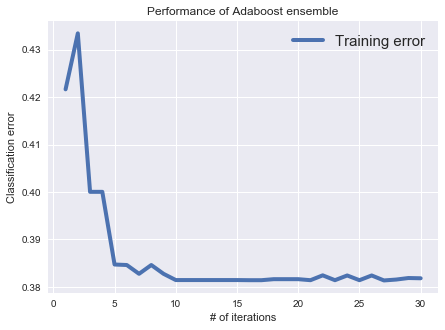

In [266]:
plt.rcParams['figure.figsize'] = 7, 5
plt.plot(range(1,31), error_all, '-', linewidth=4.0, label='Training error')
plt.title('Performance of Adaboost ensemble')
plt.xlabel('# of iterations')
plt.ylabel('Classification error')
plt.legend(loc='best', prop={'size':15})

plt.rcParams.update({'font.size': 16})

In [267]:
error_test = []
for n in range(1, 31):
    predictions = predict_adaboost(weights_30[:n], 
                                   tree_stumps_30[:n],
                                   test_data)
    
    compare = test_data[target] != predictions
    error = np.count_nonzero(compare)/ len(compare)

    error_test.append(error)
    print ("Iteration %s, training error = %s" % (n,error_test[n-1]))

Iteration 1, training error = 0.4233089185695821
Iteration 2, training error = 0.42847910383455406
Iteration 3, training error = 0.3981042654028436
Iteration 4, training error = 0.3981042654028436
Iteration 5, training error = 0.3799009047824214
Iteration 6, training error = 0.38000861697544164
Iteration 7, training error = 0.3792546316242999
Iteration 8, training error = 0.38000861697544164
Iteration 9, training error = 0.3792546316242999
Iteration 10, training error = 0.37796208530805686
Iteration 11, training error = 0.37796208530805686
Iteration 12, training error = 0.37796208530805686
Iteration 13, training error = 0.37796208530805686
Iteration 14, training error = 0.37796208530805686
Iteration 15, training error = 0.37796208530805686
Iteration 16, training error = 0.37817750969409736
Iteration 17, training error = 0.37817750969409736
Iteration 18, training error = 0.3778543731150366
Iteration 19, training error = 0.3778543731150366
Iteration 20, training error = 0.377854373115036

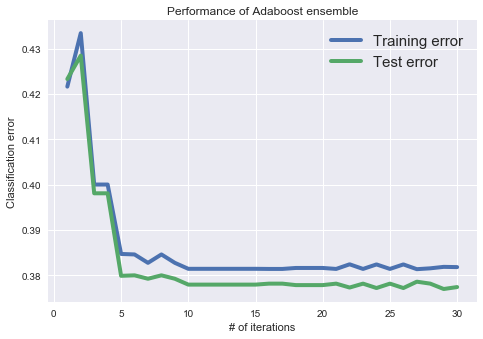

In [268]:
plt.rcParams['figure.figsize'] = 7, 5
plt.plot(range(1,31), error_all, '-', linewidth=4.0, label='Training error')
plt.plot(range(1,31), error_test, '-', linewidth=4.0, label='Test error')

plt.title('Performance of Adaboost ensemble')
plt.xlabel('# of iterations')
plt.ylabel('Classification error')
plt.rcParams.update({'font.size': 16})
plt.legend(loc='best', prop={'size':15})
plt.tight_layout()